In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline

In [ ]:
#right is source
#left is destination
left = cv2.imread("image1.jpg")
right = cv2.imread("image2.jpg")
print(left.shape[1])
print(left.shape)

1024
(683, 1024, 3)


In [ ]:
#INSTEAD of doing it manual 
arr = [[102, 502], [307, 491], [461, 497], [416, 308]]
arrbar = [[565, 543], [762, 526], [923, 525], [860, 332]]


In [ ]:
def homography(arr,arrbar):
    A = []
    for i in range(0, len(arr)):
        x, y = arr[i][0], arr[i][1]
        u, v = arrbar[i][0], arrbar[i][1]
        A.append([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
        A.append([0, 0, 0, -x, -y, -1, x*v, y*v, v])
    #Convert list to array
    A = np.asarray(A)
    #U, S, Vh = np.linalg.svd(A)
    u, s, vh = np.linalg.svd(A)

    H = vh[8].reshape((3,3))
    #Normalize h9
    H = H / H[2,2]
    return H
H = homography(arr,arrbar)
print(H)

[[ 1.26541088e+00  1.05397574e+00  2.00718106e+02]
 [-2.01487846e-01  1.83582225e+00 -7.55885169e+01]
 [-2.72107507e-04  1.09144798e-03  1.00000000e+00]]


In [ ]:
def min_max_axis (A,B,C,D):
    #used to determine the starting point , new width and height of the warped image
    min_x = min(A[0],B[0],C[0],D[0])
    max_x = max(A[0],B[0],C[0],D[0])
    min_y = min(A[1],B[1],C[1],D[1])
    max_y = max(A[1],B[1],C[1],D[1])
    return min_x , max_x , min_y , max_y

def limit(point,height):
    if point[1]<0:
        point[1]=0
    if point[1]>height:
        point[1]=height-1
    return point[1]

def boundary_box (h,N,M):
  '''
  Returns new cordinates of the bounding box
  N --> img.shape[0] -> x -> height (rows)
  M --> img.shape[1] -> x -> width (cols)
  '''
  #Top left
  A= [0,0,1]
  A_new  = np.dot(h,A)
  #Normalize
  A_new = A_new / A_new[2]
  A_new = [round(i) for i in A_new]
  A_new[1] = limit(A_new,left.shape[0])
  #Bottom left
  B=[0,N-1,1]
  B_new = np.dot(h,B )
  B_new = B_new / B_new[2]
  B_new = [round(i) for i in B_new]
  B_new[1] = limit(B_new,left.shape[0])
  #Top right
  C=[M-1,0,1]
  C_new = np.dot(h,C )
  C_new = C_new / C_new[2]
  C_new = [round(i) for i in C_new]
  C_new[1] = limit(C_new,left.shape[0])
  #Bottom right
  D=[M-1,N-1,1]
  D_new = np.dot(h,D )
  D_new = D_new / D_new[2]
  D_new = [round(i) for i in D_new]
  D_new[1] = limit(D_new,left.shape[0])
  return A_new,B_new,C_new,D_new

In [ ]:
def warp(h,img):
    A,B,C,D = boundary_box(h,img.shape[0],img.shape[1])

    min_x , max_x , min_y, max_y = min_max_axis (A,B,C,D)
    #we use min_x,min_y
    #to determine the start point of the warped image
    #we use the difference between min,max to find width,height
    #of the warped image in the destination image
    new_h = int(round(abs(max_y - min_y)))
    new_w = int(round(abs(max_x- min_x)))
    new= np.zeros((img.shape[0],new_h+img.shape[1]))
    #counter=np.zeros((img.shape[0],new_h+img.shape[1]))
   
    x = np.arange(0, img.shape[1], 1)
    y = np.arange(0, img.shape[0], 1)
    X, Y = np.meshgrid(x,y)
  
    print(X,Y)
    print("here")
    splat=griddata((x-1,y-1),img[x][y], (X,Y), method='nearest')
    print("here")
    for i in range (img.shape[1]):
        for j in range (img.shape[0]):
          point = [i,j,1]
          point = np.dot(h,point)
          point = point/point[2]
          xi=point[0]
          yi=point[1]
          if(xi>=0 and yi>=0):
            if(isinstance(xi, int) and isinstance(yi, int)):
              new[i][j]=img[i][j]  
            else:
                intensity=int(splat.ev(xi, yi))
                new[i][j] = intensity

    return new           
    

In [ ]:
def inverse_warp(src_img,dimensions,h_inv):
    #prepare x and y arrays for interpolation (meshgrid)
    x = np.arange(0, src_img.shape[1], 1)
    y = np.arange(0, src_img.shape[0], 1)
    
    blue,green,red = src_img[:, :, 0], src_img[:, :, 1], src_img[:, :, 2] 
    min_x, min_y, new_w, new_h= dimensions['min_x'], dimensions['min_y'], dimensions['new_w'], dimensions['new_h']
    
    new_img_red= np.zeros((src_img.shape[0],new_h+src_img.shape[1]))
    new_img_blue=np.zeros((src_img.shape[0],new_h+src_img.shape[1]))
    new_img_green=np.zeros((src_img.shape[0],new_h+src_img.shape[1]))
    
    f_g = RectBivariateSpline(y.reshape(-1,1), x.reshape(-1,1), green)
    f_r = RectBivariateSpline(y.reshape(-1,1), x.reshape(-1,1), red)
    f_b= RectBivariateSpline(y.reshape(-1,1), x.reshape(-1,1), blue)
  
    ##start warping loop
    for i in range (int(min_x),int(min_x+new_w),1):
        for j in range (int(min_y),int((min_y+new_h)),1):
            point = [i,j,1]
            point = np.dot(h_inv,point)
            point = point/point[2]
            xi=point[0]
            yi=point[1]
            if (xi>=0 and yi>=0):
                if(i < new_h+src_img.shape[1]):
                    intensity=int(f_r.ev(yi, xi))
                    new_img_red[j][i] = intensity

                    intensity=int(f_b.ev(yi, xi))
                    new_img_blue[j][i] = intensity

                    intensity=int(f_g.ev(yi, xi))
                    new_img_green[j][i] = intensity                    
            else:
                #If the result from h_inv * [x' y' 1] is negative we set the pixel value to 0
                new_img_red[j][i] = 0
                new_img_green[j][i] = 0
                new_img_blue[j][i] = 0
                
    return new_img_red,new_img_green,new_img_blue


In [ ]:
def warp_bgr(warped_blue,warped_red,warped_green,dimensions,src):
    rows = dimensions['rows']
    cols = dimensions['cols']
    new_h =dimensions['new_h']
    new_img = np.zeros((src.shape[0],src.shape[1]+new_h,3), 'uint8')
    new_img[:,:,0]=warped_blue
    new_img[:,:,1]=warped_green
    new_img[:,:,2]=warped_red
    
    return new_img
    

In [ ]:
def perform_warping(h,src):
    ## check the bounding box position and size of the warped image using forward warping.
    A,B,C,D = boundary_box(h,src.shape[0],src.shape[1])

    min_x , max_x , min_y, max_y = min_max_axis (A,B,C,D)
    #we use min_x,min_y
    #to determine the start point of the warped image
    #we use the difference between min,max to find width,height
    #of the warped image in the destination image
    new_h = int(round(abs(max_y - min_y)))
    new_w = int(round(abs(max_x- min_x)))
            
    dimensions = {'min_x':min_x,'min_y':min_y,'new_w':new_w,'new_h':new_h}
  
    h_inv = np.linalg.inv(h)

    warped_red,warped_green,warped_blue= inverse_warp(src,dimensions,h_inv)
    
    #New image dimensions(final output after sitching)
    dimensions['rows'] = src.shape[0]
    dimensions['cols'] = src.shape[1]+new_h

    warped_img = warp_bgr(warped_blue,warped_red,warped_green,dimensions,src)

    return warped_img

In [ ]:
warped_img = perform_warping(H,right)

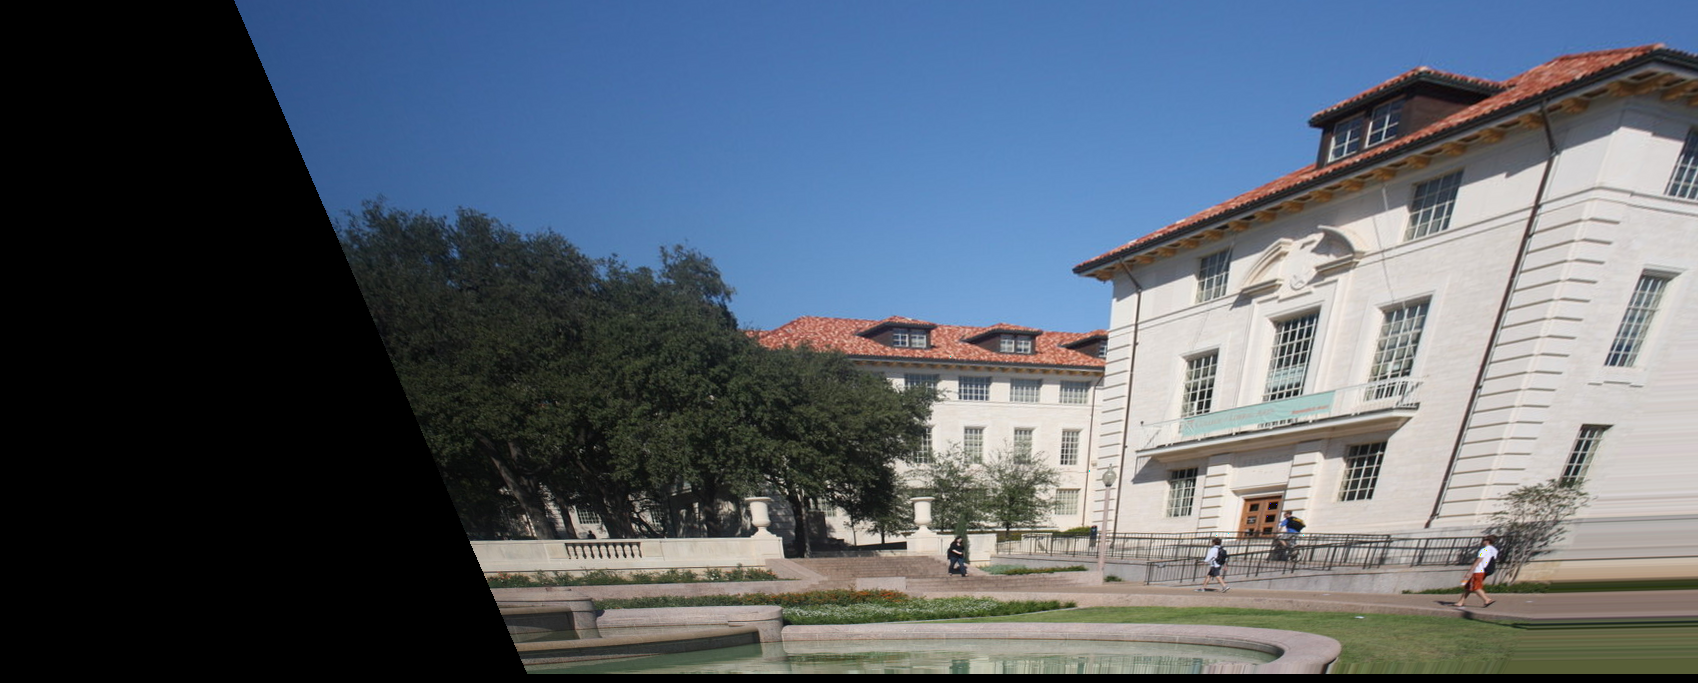

In [ ]:
cv2_imshow(warped_img)

In [ ]:
def stitch_images(warped_img,dst):
    warped_img[0:dst.shape[0],0:dst.shape[1]]= dst
    return warped_img
    

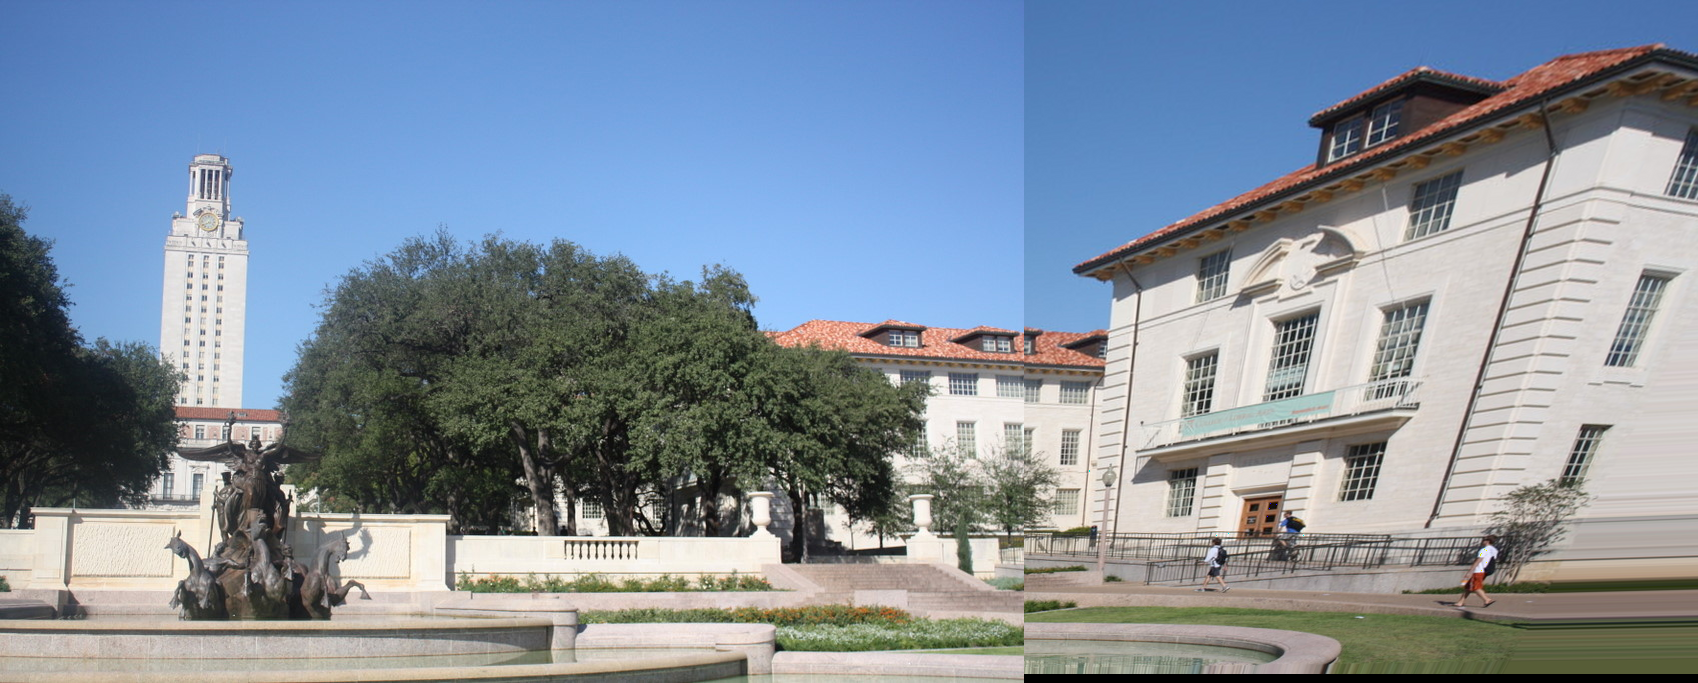

In [ ]:
stitched_img = stitch_images(warped_img,left)
cv2_imshow(stitched_img)

In [ ]:
median = cv2.medianBlur(stitched_img,3)
cv2_imshow(median)